# Natural Drivers of Coastal Erosion - EDA and Predictive Model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

In [ ]:
n_samples = 10000 # we will be generating 10000 samples

# Base values with realistic correlations
# Generate wave energy (0.5-5.0 kW/m)
wave_energy = np.random.gamma(shape=2.0, scale=1.0, size=n_samples)
wave_energy = np.clip(wave_energy, 0.5, 5.0)

# Generate tidal range (1.0-10.0 m)
tidal_range = np.random.lognormal(mean=1.5, sigma=0.5, size=n_samples)
tidal_range = np.clip(tidal_range, 1.0, 10.0)

# Generate storm frequency (1-20 events/year, skewed distribution)
storm_frequency = np.random.poisson(lam=5, size=n_samples)
storm_frequency = np.clip(storm_frequency, 1, 20)

# Generate sea level rise rate (0.01-0.1 m/year)
# Using a distribution that's weighted toward lower values but with some higher outliers
sea_level_rise_rate = np.random.beta(a=2, b=10, size=n_samples) * 0.09 + 0.01

# Create sediment transport rate with negative correlation to wave energy
sediment_base = np.random.normal(size=n_samples)
# Mix in negative correlation with wave energy
sediment_transport_rate = 1.0 - 0.3*wave_energy/5.0 + 0.7*sediment_base
# Scale to desired range (0.1-2.0 units)
sediment_transport_rate = (sediment_transport_rate - sediment_transport_rate.min()) / \
                          (sediment_transport_rate.max() - sediment_transport_rate.min()) * 1.9 + 0.1

# Generate erosion rate based on realistic correlations with drivers
erosion_rate = (
    0.4 * wave_energy/5.0 +
    0.25 * tidal_range/10.0 +
    -0.3 * sediment_transport_rate/2.0 +
    0.35 * sea_level_rise_rate/0.1 +
    0.2 * storm_frequency/20.0 +
    np.random.normal(0, 0.15, n_samples)     # Add some noise to maintain complexity
)

# Scale erosion rate to realistic range (0.1-5.0 m/year)
erosion_rate = erosion_rate * 2.5 + 2.5
erosion_rate = np.clip(erosion_rate, 0.1, 5.0)

In [ ]:
# Create a dataframe
coastal_data = pd.DataFrame({
    'wave_energy': wave_energy,
    'tidal_range': tidal_range,
    'sediment_transport_rate': sediment_transport_rate,
    'sea_level_rise_rate': sea_level_rise_rate,
    'storm_frequency': storm_frequency,
    'erosion_rate': erosion_rate
})

coastal_data.describe()

,wave_energy,tidal_range,sediment_transport_rate,sea_level_rise_rate,storm_frequency,erosion_rate
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.985463,4.952826,1.082242,0.024894,5.004700,3.142790
std,1.251166,2.274906,0.250487,0.009222,2.220129,0.491793
min,0.500000,1.000000,0.100000,0.010120,1.000000,1.449335
25%,0.983165,3.187988,0.914242,0.017795,3.000000,2.799030
50%,1.691654,4.477039,1.084681,0.023327,5.000000,3.128805
75%,2.710662,6.283258,1.245669,0.030291,6.000000,3.470230
max,5.000000,10.000000,2.000000,0.070720,17.000000,5.000000


In [ ]:
coastal_data.head()

,wave_energy,tidal_range,sediment_transport_rate,sea_level_rise_rate,storm_frequency,erosion_rate
0,2.393679,2.254212,0.742449,0.026574,4,3.431640
1,1.494465,8.715183,1.018655,0.014461,3,2.638809
2,1.382284,5.783375,1.058322,0.024147,6,3.569684
3,1.382302,9.827138,0.905981,0.020162,5,3.414795
4,4.649714,1.310182,1.113168,0.013893,5,3.330336


In [ ]:
# Calculate correlation matrix
correlation_matrix = coastal_data.corr()
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,wave_energy,tidal_range,sediment_transport_rate,sea_level_rise_rate,storm_frequency,erosion_rate
wave_energy,1.000000,0.000260,-0.104430,-0.003955,-0.009382,0.527487
tidal_range,0.000260,1.000000,-0.005680,-0.003265,0.012805,0.282199
sediment_transport_rate,-0.104430,-0.005680,1.000000,0.013204,-0.001280,-0.237467
sea_level_rise_rate,-0.003955,-0.003265,0.013204,1.000000,-0.010807,0.152052
storm_frequency,-0.009382,0.012805,-0.001280,-0.010807,1.000000,0.112459
erosion_rate,0.527487,0.282199,-0.237467,0.152052,0.112459,1.000000


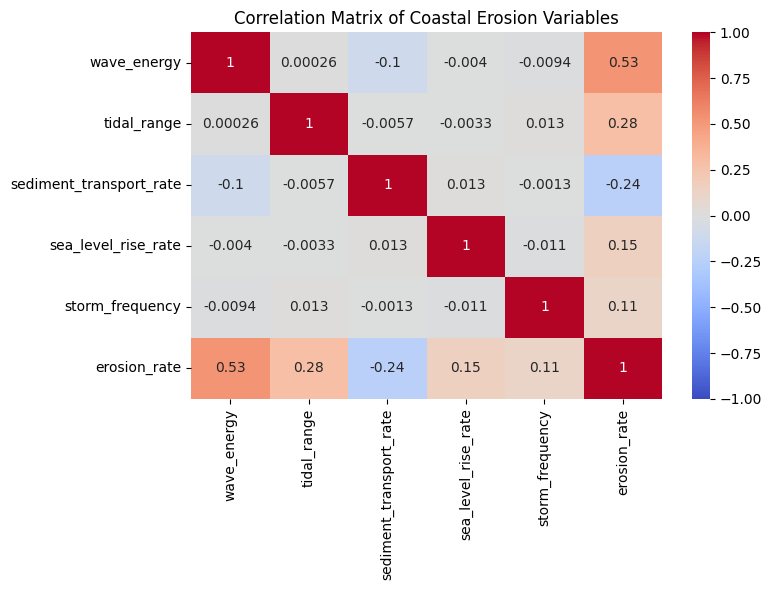

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Coastal Erosion Variables')
plt.tight_layout()
plt.show()

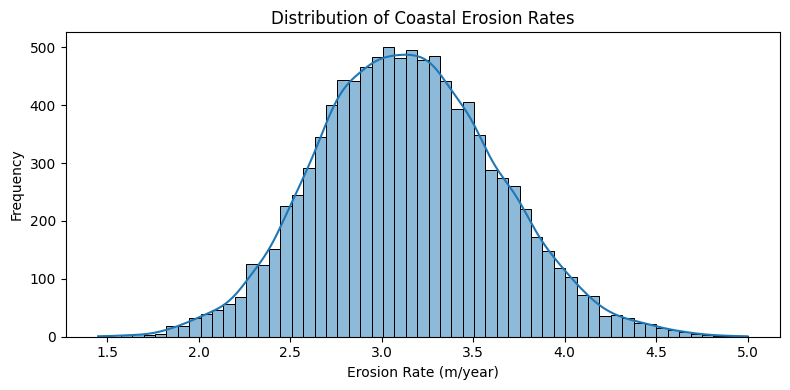

In [ ]:
# Distribution of erosion rates
plt.figure(figsize=(8, 4))
sns.histplot(coastal_data['erosion_rate'], kde=True)
plt.title('Distribution of Coastal Erosion Rates')
plt.xlabel('Erosion Rate (m/year)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

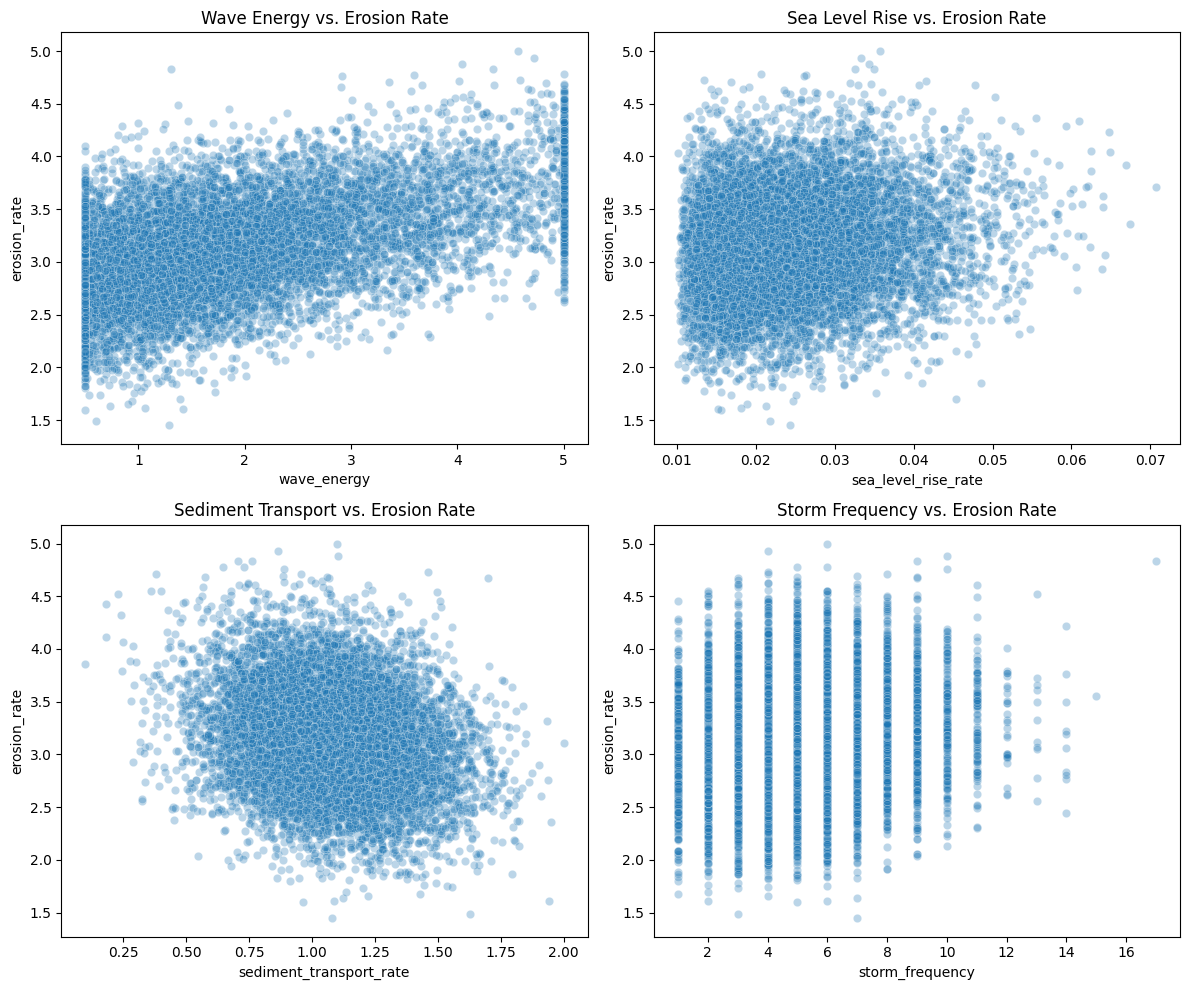

In [ ]:
# Scatter plots of key relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(x='wave_energy', y='erosion_rate', data=coastal_data, ax=axes[0,0], alpha=0.3)
axes[0,0].set_title('Wave Energy vs. Erosion Rate')

sns.scatterplot(x='sea_level_rise_rate', y='erosion_rate', data=coastal_data, ax=axes[0,1], alpha=0.3)
axes[0,1].set_title('Sea Level Rise vs. Erosion Rate')

sns.scatterplot(x='sediment_transport_rate', y='erosion_rate', data=coastal_data, ax=axes[1,0], alpha=0.3)
axes[1,0].set_title('Sediment Transport vs. Erosion Rate')

sns.scatterplot(x='storm_frequency', y='erosion_rate', data=coastal_data, ax=axes[1,1], alpha=0.3)
axes[1,1].set_title('Storm Frequency vs. Erosion Rate')

plt.tight_layout()
plt.show()

In [ ]:
# Training the model
X = coastal_data[['wave_energy', 'tidal_range', 'sediment_transport_rate',
                  'sea_level_rise_rate', 'storm_frequency']]
y = coastal_data['erosion_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
# Evaluating the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Feature Importances:")
for feature, importance in zip(X.columns, model.feature_importances_):
    print(f"- {feature}: {importance:.4f}")

Mean Squared Error: 0.1401
R² Score: 0.4088
Feature Importances:
- wave_energy: 0.4926
- tidal_range: 0.1981
- sediment_transport_rate: 0.1397
- sea_level_rise_rate: 0.1183
- storm_frequency: 0.0513


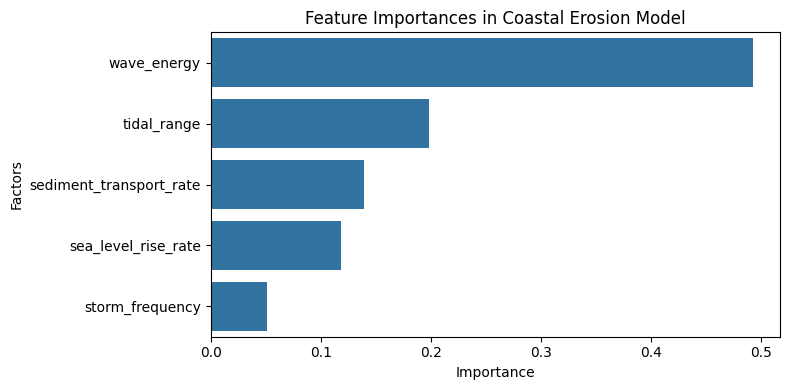

In [ ]:
# Plot feature importances
plt.figure(figsize=(8, 4))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title('Feature Importances in Coastal Erosion Model')
plt.xlabel('Importance')
plt.ylabel('Factors')
plt.tight_layout()
plt.savefig('improved_feature_importances.png')